In [2]:
print(np_data[:200,:])
print(np_data[:200,[0,1,3,5,6,7,10,11,12,13,14,17,18,19,22,23,24]].shape)
np_data[:200,[5,7,10,14,17,19,22,24]])
np_data[:200,[4,10,17]])

SyntaxError: unmatched ')' (686267680.py, line 3)

In [1]:
import sys
sys.path.append("/root/autodl-tmp/pykan-master")
from kan import *
import torch
from kan import KAN, create_dataset
import pandas as pd
import numpy as np

def split_validation_column(train_input, column_idx, val_ratio=0.2):
    """
    从训练数据中分离出指定列作为验证集
    
    参数:
    train_input (torch.Tensor): 输入的训练数据张量
    column_idx (int): 要选择作为验证集的列索引
    val_ratio (float): 验证集占原始数据的比例，默认为0.2
    
    返回:
    train_data (torch.Tensor): 剩余的训练数据
    val_data (torch.Tensor): 选出的验证数据
    """
    
    # 获取数据总长度
    total_size = train_input.shape[0]
    
    # 计算验证集大小
    val_size = int(total_size * val_ratio)
    train_size = total_size - val_size
    
    # 随机打乱索引
    indices = torch.randperm(total_size)
    
    # 分割索引
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]
    
    # 分离出指定列
    train_out = train_input[train_indices, column_idx].unsqueeze(1)  # 添加维度保持2D形状
    val_out = train_input[val_indices, column_idx].unsqueeze(1)  # 添加维度保持2D形状
    # 创建新的训练数据，去掉验证集的那一列
    train_data = torch.cat((train_input[:, :column_idx], 
                           train_input[:, column_idx+1:]), dim=1)
    train_in = train_data[train_indices]
    val_in = train_data[val_indices]
    
    return train_in, val_in, train_out, val_out



# Device setup: Use GPU if available, otherwise fall back to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create the KAN model and move it to the GPU
model = KAN(width=[14, 20, 10, 1], grid=10, k=3, seed=1).to(device)

# Define a sample function and create a dataset (for demonstration)
f = lambda x: torch.exp((torch.sin(torch.pi * (x[:, [0]]**2 + x[:, [1]]**2)) + torch.sin(torch.pi * (x[:, [2]]**2 + x[:, [3]]**2))) / 2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# Load and process the CSV data
df = pd.read_csv('Airline_Delay_Cause.csv')

# # Process timestamp: Convert to Unix timestamp (seconds since 1970)
# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
# df['timestamp'] = df['timestamp'].apply(lambda x: x.timestamp()).astype('float64')

# # Process risk_classification: Map categories to numerical values
# risk_map = {'Low Risk': 0.0, 'Moderate Risk': 0.5, 'High Risk': 1.0}
# df['risk_classification'] = df['risk_classification'].map(risk_map).astype('float64')

# Convert DataFrame to NumPy array with float32 type

df = df.iloc[:, 6:]
# print(df)
structured_array = df.to_numpy().astype(np.float32)

# Standardization function: Normalize along dimension 0
def normalize_along_dim0(tensor):
    mean = tensor.mean(dim=0)
    std = tensor.std(dim=0, unbiased=True)
    normalized_tensor = (tensor - mean) / (std + 1e-8)  # Add small constant to avoid division by zero
    return normalized_tensor

# Split data into train and test sets and move to GPU

# structured_array = np.nan_to_num(structured_array, nan=0.0, posinf=0.0, neginf=0.0)
train_input = torch.from_numpy(structured_array[:30000, :]).float().to(device)
print(train_input[:10])
print(train_input.shape)  # 确认张量形状
print(torch.isnan(train_input).any())  # 检查是否有 NaN
print(torch.isinf(train_input).any())  # 检查是否有 Inf
mask = ~torch.isnan(train_input).any(dim=1)
train_input = train_input[mask]
train_input = normalize_along_dim0(train_input)
# print(train_input[:10])
train_input, test_input, train_label, test_label = split_validation_column(train_input, 9)

# print(train_input[:10])
# print(train_label[:10])

# col_to_remove = 2
# train_input = torch.cat((train_input[:, :col_to_remove], train_input[:, col_to_remove + 1:]), dim=1)
# test_input = torch.cat((test_input[:, :col_to_remove], test_input[:, col_to_remove + 1:]), dim=1)
# train_label = torch.from_numpy(structured_array[:10000, 2+1:2+2]).float().to(device)
# test_label = torch.from_numpy(structured_array[29000:, 2+1:2+2]).float().to(device)

# Normalize the data
# train_input = normalize_along_dim0(train_input)
# test_input = normalize_along_dim0(test_input)
# train_label = normalize_along_dim0(train_label)
# test_label = normalize_along_dim0(test_label)

# Update dataset with processed data
dataset['train_input'] = train_input
dataset['test_input'] = test_input
dataset['train_label'] = train_label
dataset['test_label'] = test_label

# Print shapes to verify
print(dataset['train_input'].shape, dataset['test_input'].shape, dataset['train_label'].shape, dataset['test_label'].shape)

# Train the model on GPU
model.fit(dataset, opt="LBFGS", steps=20)

Using device: cuda
checkpoint directory created: ./model
saving model version 0.0
tensor([[8.9000e+01, 1.3000e+01, 2.2500e+00, 1.6000e+00, 3.1600e+00, 0.0000e+00,
         5.9900e+00, 2.0000e+00, 1.0000e+00, 1.3750e+03, 7.1000e+01, 7.6100e+02,
         1.1800e+02, 0.0000e+00, 4.2500e+02],
        [6.2000e+01, 1.0000e+01, 1.9700e+00, 4.0000e-02, 5.7000e-01, 0.0000e+00,
         7.4200e+00, 0.0000e+00, 1.0000e+00, 7.9900e+02, 2.1800e+02, 1.0000e+00,
         6.2000e+01, 0.0000e+00, 5.1800e+02],
        [6.2000e+01, 1.0000e+01, 2.7300e+00, 1.1800e+00, 1.8000e+00, 0.0000e+00,
         4.2800e+00, 1.0000e+00, 0.0000e+00, 7.6600e+02, 5.6000e+01, 1.8800e+02,
         7.8000e+01, 0.0000e+00, 4.4400e+02],
        [6.6000e+01, 1.2000e+01, 3.6900e+00, 2.2700e+00, 4.4700e+00, 0.0000e+00,
         1.5700e+00, 1.0000e+00, 1.0000e+00, 1.3970e+03, 4.7100e+02, 3.2000e+02,
         3.8800e+02, 0.0000e+00, 2.1800e+02],
        [9.2000e+01, 2.2000e+01, 7.7600e+00, 0.0000e+00, 2.9600e+00, 0.0000e+00,
     

| train_loss: 4.61e-03 | test_loss: 4.15e-02 | reg: 6.88e+01 | : 100%|█| 20/20 [00:12<00:00,  1.56it

saving model version 0.1


{'train_loss': [array(0.1558811, dtype=float32),
  array(0.03955888, dtype=float32),
  array(0.02415301, dtype=float32),
  array(0.01731918, dtype=float32),
  array(0.01321877, dtype=float32),
  array(0.01074121, dtype=float32),
  array(0.00922901, dtype=float32),
  array(0.00798916, dtype=float32),
  array(0.00729885, dtype=float32),
  array(0.00674953, dtype=float32),
  array(0.00648418, dtype=float32),
  array(0.00597091, dtype=float32),
  array(0.00562548, dtype=float32),
  array(0.00533295, dtype=float32),
  array(0.00515701, dtype=float32),
  array(0.00527628, dtype=float32),
  array(0.00508896, dtype=float32),
  array(0.00492604, dtype=float32),
  array(0.00479141, dtype=float32),
  array(0.00461183, dtype=float32)],
 'test_loss': [array(0.18419461, dtype=float32),
  array(0.04649241, dtype=float32),
  array(0.02813099, dtype=float32),
  array(0.02234216, dtype=float32),
  array(0.01681884, dtype=float32),
  array(0.04127231, dtype=float32),
  array(0.04049316, dtype=float32),
 


Variance Inflation Factors (VIF):
                Feature        VIF
0            carrier_ct  22.015168
1            weather_ct  13.253060
2                nas_ct  22.082163
3           security_ct   4.533323
4      late_aircraft_ct  28.160635
5         arr_cancelled   1.847123
6          arr_diverted   2.524685
7         carrier_delay  20.841150
8         weather_delay  12.117946
9             nas_delay  19.170553
10       security_delay   4.120998
11  late_aircraft_delay  27.054890


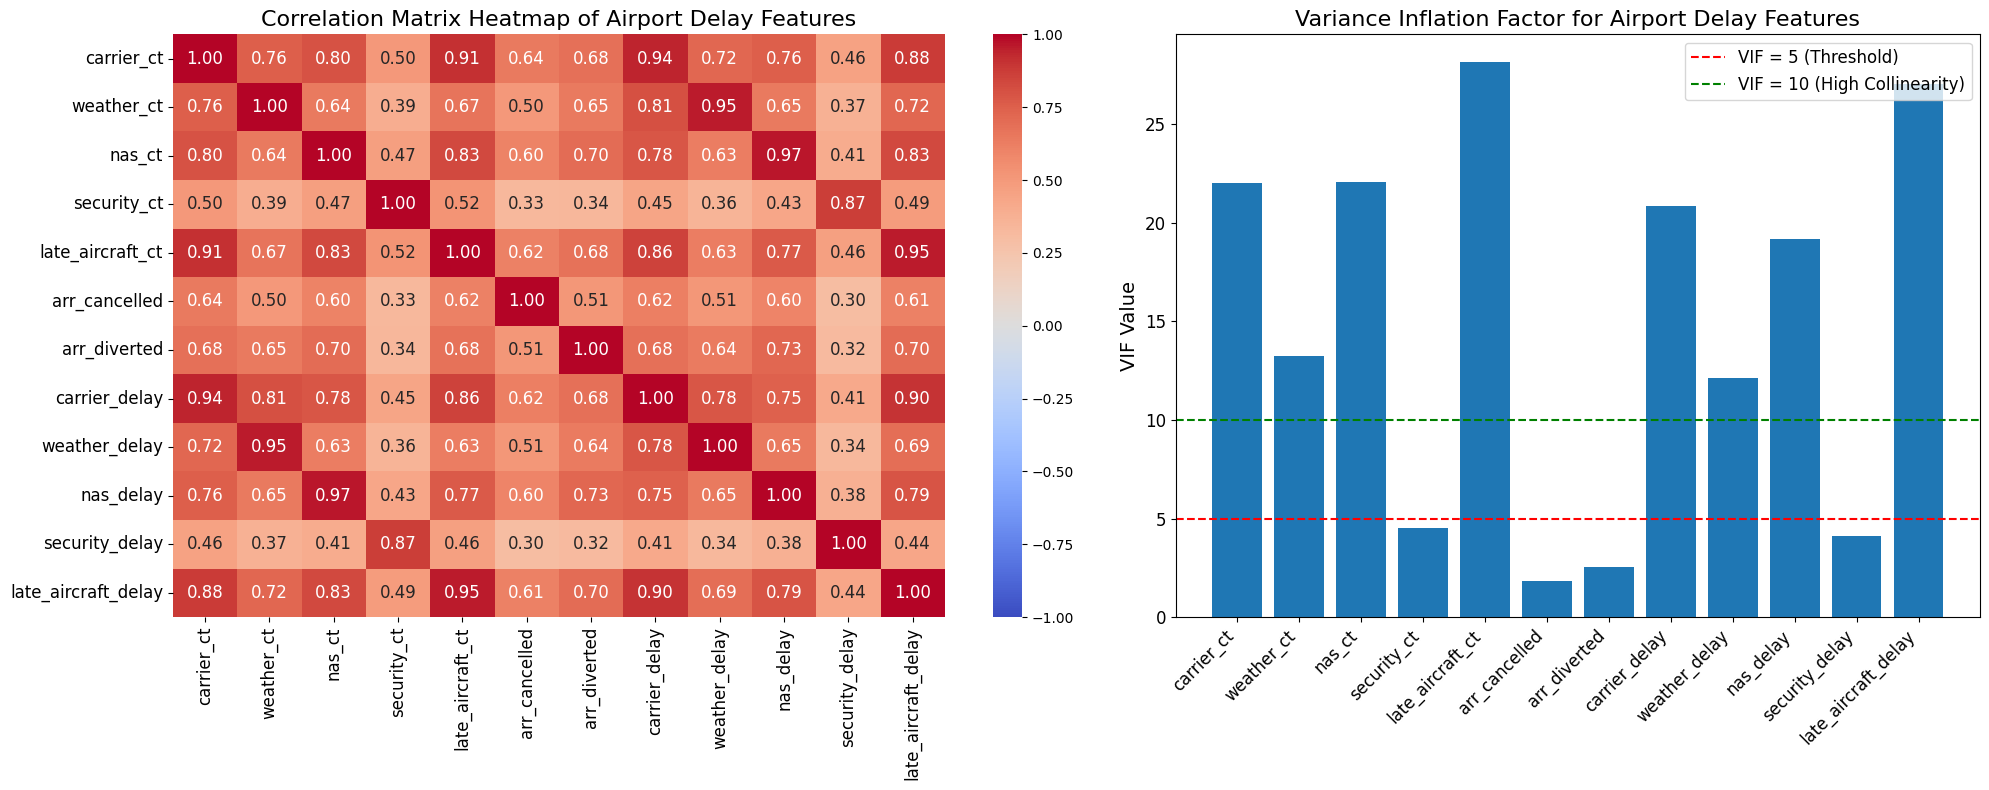


Interpretation:
- VIF < 5: No significant multicollinearity
- 5 ≤ VIF < 10: Moderate multicollinearity
- VIF ≥ 10: High multicollinearity that may need attention


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 假设 train_input 是您的 PyTorch 张量数据
df = pd.DataFrame(train_input[:, 2:].cpu(), columns=[
    'carrier_ct', 'weather_ct', 'nas_ct',
    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 
    'carrier_delay', 'weather_delay', 'nas_delay', 
    'security_delay', 'late_aircraft_delay'
])

# 1. 计算相关系数矩阵
corr_matrix = df.corr()

# 2. 计算VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) 
                       for i in range(df.shape[1])]
    return vif_data

vif_results = calculate_vif(df)
print("\nVariance Inflation Factors (VIF):")
print(vif_results)

# 3. 创建横排子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1.2, 1]})

# 4. 绘制相关性热图（左图）
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', annot_kws={"size": 12}, ax=ax1)  # 增大热图注解字号
ax1.set_title('Correlation Matrix Heatmap of Airport Delay Features', fontsize=16)  # 标题字号
ax1.tick_params(axis='both', labelsize=12)  # 刻度标签字号

# 5. 绘制VIF条形图（右图）
ax2.bar(vif_results['Feature'], vif_results['VIF'])
ax2.axhline(y=5, color='r', linestyle='--', label='VIF = 5 (Threshold)')
ax2.axhline(y=10, color='g', linestyle='--', label='VIF = 10 (High Collinearity)')
ax2.set_xticks(range(len(vif_results['Feature'])))
ax2.set_xticklabels(vif_results['Feature'], rotation=45, ha='right', fontsize=12)  # X轴刻度标签字号
ax2.set_ylabel('VIF Value', fontsize=14)  # Y轴标签字号
ax2.set_title('Variance Inflation Factor for Airport Delay Features', fontsize=16)  # 标题字号
ax2.tick_params(axis='y', labelsize=12)  # Y轴刻度标签字号
ax2.legend(fontsize=12)  # 图例字号

# 调整布局
plt.tight_layout()
plt.show()

# 6. 分析结果
print("\nInterpretation:")
print("- VIF < 5: No significant multicollinearity")
print("- 5 ≤ VIF < 10: Moderate multicollinearity")
print("- VIF ≥ 10: High multicollinearity that may need attention")


Variance Inflation Factors (VIF):
                Feature        VIF
0            carrier_ct  22.015168
1            weather_ct  13.253060
2                nas_ct  22.082163
3           security_ct   4.533323
4      late_aircraft_ct  28.160635
5         arr_cancelled   1.847123
6          arr_diverted   2.524685
7         carrier_delay  20.841150
8         weather_delay  12.117946
9             nas_delay  19.170553
10       security_delay   4.120998
11  late_aircraft_delay  27.054890


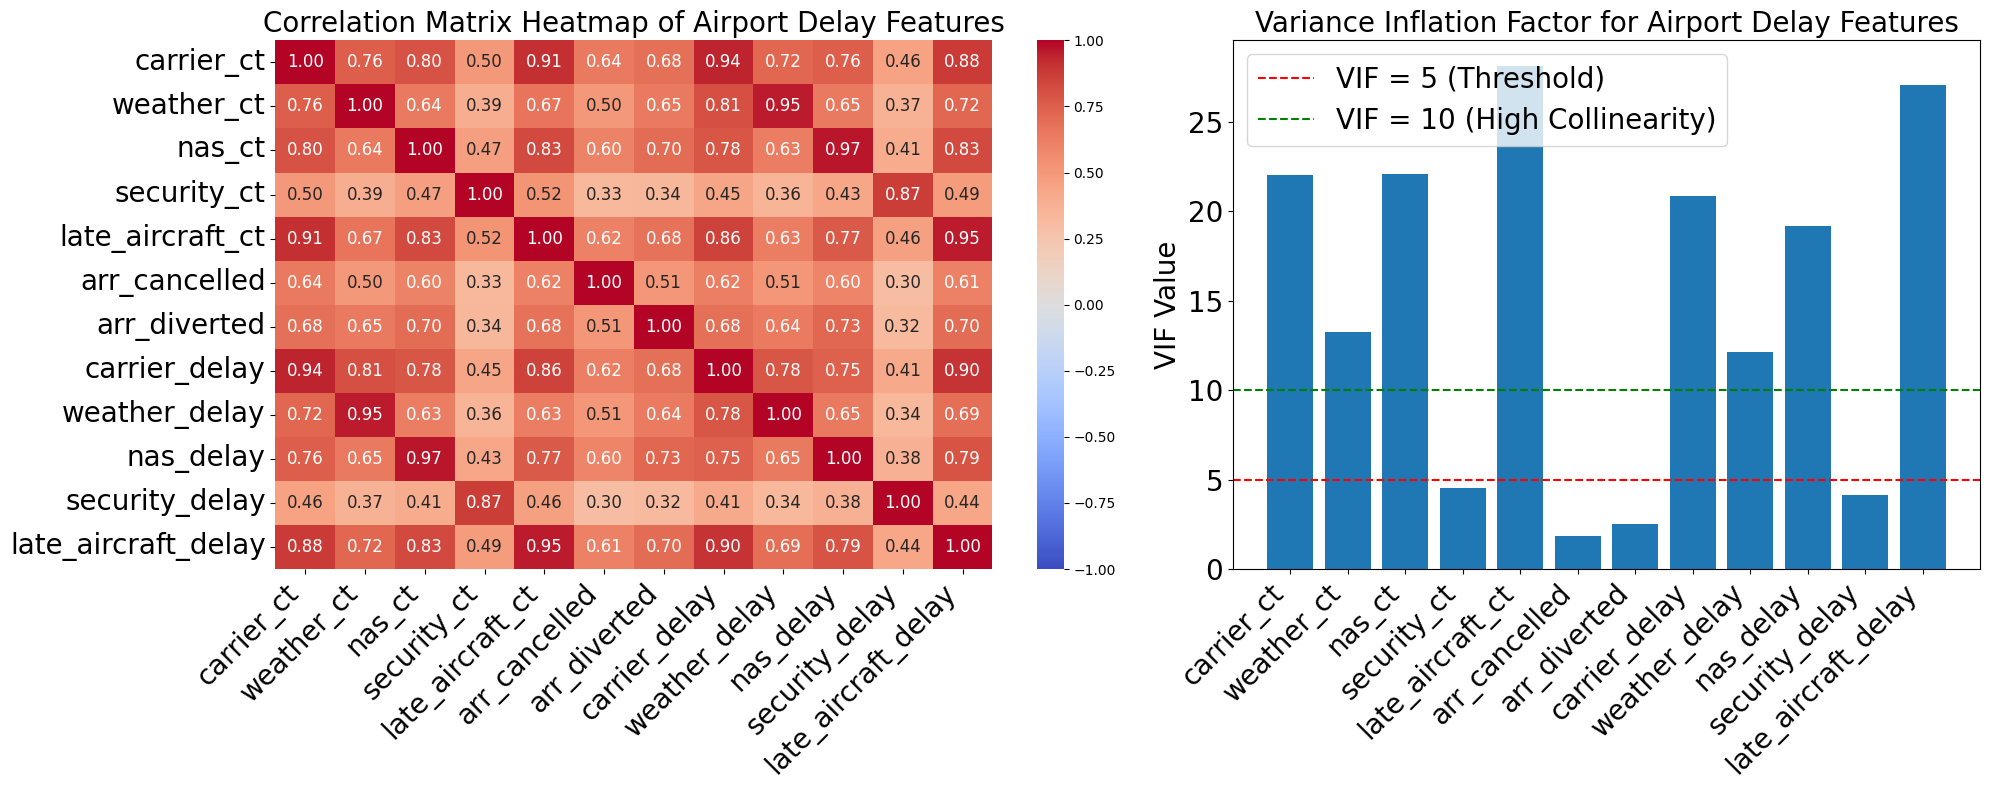


Interpretation:
- VIF < 5: No significant multicollinearity
- 5 ≤ VIF < 10: Moderate multicollinearity
- VIF ≥ 10: High multicollinearity that may need attention


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 假设 train_input 是您的 PyTorch 张量数据
df = pd.DataFrame(train_input[:, 2:].cpu(), columns=[
    'carrier_ct', 'weather_ct', 'nas_ct',
    'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 
    'carrier_delay', 'weather_delay', 'nas_delay', 
    'security_delay', 'late_aircraft_delay'
])

# 1. 计算相关系数矩阵
corr_matrix = df.corr()

# 2. 计算VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) 
                       for i in range(df.shape[1])]
    return vif_data

vif_results = calculate_vif(df)
print("\nVariance Inflation Factors (VIF):")
print(vif_results)

# 3. 创建横排子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1.2, 1]})

# 4. 绘制相关性热图（左图）
# 4. 绘制相关性热图（左图）
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', annot_kws={"size": 12}, ax=ax1)  # 增大热图注解字号
ax1.set_title('Correlation Matrix Heatmap of Airport Delay Features', fontsize=20)
ax1.tick_params(axis='both', labelsize=20)
# 添加这行来倾斜 x 轴标签
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=20)

# 5. 绘制VIF条形图（右图）
ax2.bar(vif_results['Feature'], vif_results['VIF'])
ax2.axhline(y=5, color='r', linestyle='--', label='VIF = 5 (Threshold)')
ax2.axhline(y=10, color='g', linestyle='--', label='VIF = 10 (High Collinearity)')
ax2.set_xticks(range(len(vif_results['Feature'])))
ax2.set_xticklabels(vif_results['Feature'], rotation=45, ha='right', fontsize=20)  # X轴刻度标签字号到22
ax2.set_ylabel('VIF Value', fontsize=20)  # Y轴标签字号到22
ax2.set_title('Variance Inflation Factor for Airport Delay Features', fontsize=20)  # 标题字号到22
ax2.tick_params(axis='y', labelsize=20)  # Y轴刻度标签字号到22
ax2.legend(fontsize=20)  # 图例字号到22

# 调整布局
plt.tight_layout()
plt.show()

# 6. 分析结果
print("\nInterpretation:")
print("- VIF < 5: No significant multicollinearity")
print("- 5 ≤ VIF < 10: Moderate multicollinearity")
print("- VIF ≥ 10: High multicollinearity that may need attention")

In [ ]:
model = model.prune(edge_th=1e-3)
model = model.refine(20)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=20);

In [23]:

model = model.prune(edge_th=1e-2)
model = model.refine(30)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: 0.00e+00 | :   3%|▏       | 3/100 [00:03<02:08,  1.32s/it]


KeyboardInterrupt: 

In [8]:
model = model.prune(edge_th=5e-2)
model = model.refine(50)
# model.fit(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=2.);
model.fit(dataset, opt="LBFGS", steps=100);

saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 100/100 [03:03<00:00,  1.83s/it]

saving model version 0.10


In [30]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.992268979549408, c=1
fixing (0,0,1) with x, r2=0.9778707027435303, c=1
fixing (0,0,2) with x, r2=0.9828502535820007, c=1
fixing (0,0,3) with x, r2=0.9891645312309265, c=1
fixing (0,0,4) with x, r2=0.795764148235321, c=1
fixing (0,0,5) with x, r2=0.9811017513275146, c=1
fixing (0,0,6) with x, r2=0.917519748210907, c=1
fixing (0,0,7) with x, r2=0.9669530987739563, c=1
fixing (0,0,8) with x, r2=0.9764853119850159, c=1
fixing (0,0,9) with x, r2=0.996070384979248, c=1
fixing (0,0,10) with x, r2=0.8891808986663818, c=1
fixing (0,0,11) with x, r2=0.9229486584663391, c=1
fixing (0,0,12) with x, r2=0.9266219735145569, c=1
fixing (0,0,13) with x, r2=0.721966028213501, c=1
fixing (0,0,14) with x, r2=0.9825007319450378, c=1
fixing (0,0,15) with x, r2=0.9766477346420288, c=1
fixing (0,0,16) with x, r2=0.970497190952301, c=1
fixing (0,1,0) with 0
fixing (0,1,1) with x, r2=0.9904028177261353, c=1
fixing (0,1,2) with x, r2=0.9964136481285095, c=1
fixing (0,1,3) with x, r2=0

0.0234*x_1 + 0.3599*x_10 + 0.0605*x_11 + 0.2014*x_12 + 0.024*x_13 + 0.4498*x_14 + 0.054*x_2 - 0.0219*x_3 + 0.012*x_4 - 0.0353*x_5 - 0.0043*x_6 - 0.0519*x_7 + 0.0257*x_8 - 0.0032*x_9 + 0.1862*sin(0.0322*x_1 - 0.0083*x_10 + 0.0127*x_11 + 0.0219*x_12 - 0.0214*x_14 - 0.0354*x_2 + 0.0103*x_3 - 0.0052*x_4 - 0.0131*x_5 - 0.0023*x_6 + 0.0348*x_7 + 0.0383*x_8 - 0.0045*tan(1.8316*x_9 + 7.8003) + 8.4909) + 0.4192*sin(0.0342*x_1 - 0.0088*x_10 + 0.0135*x_11 + 0.0233*x_12 - 0.0227*x_14 - 0.0376*x_2 + 0.0109*x_3 - 0.0056*x_4 - 0.0139*x_5 - 0.0025*x_6 + 0.037*x_7 + 0.0407*x_8 - 0.0048*tan(1.8316*x_9 + 7.8003) + 8.5125) + 0.2834*sin(0.0201*x_1 + 0.0803*x_10 + 0.0212*x_11 + 0.0426*x_12 + 0.0109*x_13 + 0.1045*x_14 + 0.0687*x_2 - 0.0494*x_3 + 0.0005*x_4 - 0.0802*x_5 - 0.0084*x_6 - 0.0883*x_7 + 0.0202*x_8 - 0.0243*x_9 - 1.3111) + 0.0014*tan(0.8722*x_9 - 1.5962) + 0.0003*tan(3.2517*x_9 - 4.8023) + 0.0001*tan(5.4643*x_9 - 8.0043) + 0.0002*tan(8.5506*x_9 - 1.804) - 0.2958 - 0.0006*exp(-6.0334*x_10)

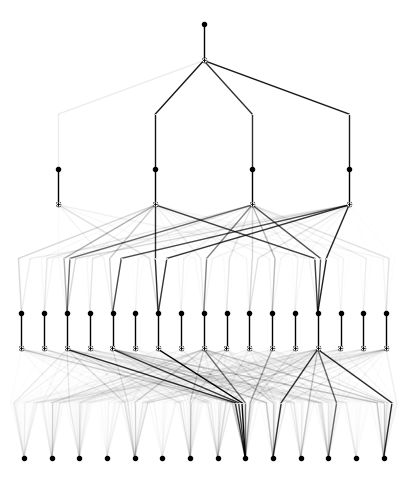

In [29]:

model.plot()

In [31]:
model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 2.46e-03 | test_loss: 2.58e-03 | reg: 0.00e+00 | : 100%|█| 100/100 [04:01<00:00,  2.42

saving model version 0.9


In [32]:
formula = model.symbolic_formula()[0][0]
print(ex_round(formula, 6))
ex_round(formula, 6)

0.007175*x_1 + 0.361386*x_10 + 0.066261*x_11 + 0.203938*x_12 + 0.003782*x_13 + 0.407646*x_14 + 0.080497*x_2 - 0.023767*x_3 - 0.003992*x_4 - 0.026114*x_5 - 0.001403*x_6 - 0.017877*x_7 + 0.01171*x_8 + 0.002264*x_9 + 0.1752*sin(0.02528*x_1 - 0.009958*x_10 + 0.011566*x_11 + 0.021697*x_12 - 0.021146*x_14 - 0.037964*x_2 + 0.008549*x_3 - 0.006235*x_4 - 0.015901*x_5 - 0.003785*x_6 + 0.027522*x_7 + 0.030122*x_8 - 0.003423*tan(1.834435*x_9 + 7.776092) + 8.469983) + 0.41752*sin(0.026681*x_1 - 0.01051*x_10 + 0.012207*x_11 + 0.0229*x_12 - 0.022318*x_14 - 0.040068*x_2 + 0.009023*x_3 - 0.006581*x_4 - 0.016782*x_5 - 0.003995*x_6 + 0.029047*x_7 + 0.031791*x_8 - 0.003613*tan(1.834435*x_9 + 7.776092) + 8.490103) - 0.19191*sin(-0.019771*x_1 - 0.075762*x_10 - 0.01433*x_11 - 0.044286*x_12 + 0.002651*x_13 - 0.098906*x_14 - 0.062154*x_2 + 0.058925*x_3 + 0.019138*x_4 + 0.083823*x_5 + 0.009142*x_6 + 0.089338*x_7 - 0.02037*x_8 + 0.02521*x_9 + 1.123854) - 0.000531*tan(0.873962*x_9 - 1.602526) - 1.5e-5*tan(1.83443

0.007175*x_1 + 0.361386*x_10 + 0.066261*x_11 + 0.203938*x_12 + 0.003782*x_13 + 0.407646*x_14 + 0.080497*x_2 - 0.023767*x_3 - 0.003992*x_4 - 0.026114*x_5 - 0.001403*x_6 - 0.017877*x_7 + 0.01171*x_8 + 0.002264*x_9 + 0.1752*sin(0.02528*x_1 - 0.009958*x_10 + 0.011566*x_11 + 0.021697*x_12 - 0.021146*x_14 - 0.037964*x_2 + 0.008549*x_3 - 0.006235*x_4 - 0.015901*x_5 - 0.003785*x_6 + 0.027522*x_7 + 0.030122*x_8 - 0.003423*tan(1.834435*x_9 + 7.776092) + 8.469983) + 0.41752*sin(0.026681*x_1 - 0.01051*x_10 + 0.012207*x_11 + 0.0229*x_12 - 0.022318*x_14 - 0.040068*x_2 + 0.009023*x_3 - 0.006581*x_4 - 0.016782*x_5 - 0.003995*x_6 + 0.029047*x_7 + 0.031791*x_8 - 0.003613*tan(1.834435*x_9 + 7.776092) + 8.490103) - 0.19191*sin(-0.019771*x_1 - 0.075762*x_10 - 0.01433*x_11 - 0.044286*x_12 + 0.002651*x_13 - 0.098906*x_14 - 0.062154*x_2 + 0.058925*x_3 + 0.019138*x_4 + 0.083823*x_5 + 0.009142*x_6 + 0.089338*x_7 - 0.02037*x_8 + 0.02521*x_9 + 1.123854) - 0.000531*tan(0.873962*x_9 - 1.602526) - 1.5e-5*tan(1.83443

In [ ]:
0.0065185404*x_1 - 0.0015733551*x_2 + 0.0023067647*x_3 - 0.0002042616*x_5 + 0.0093320001*x_6 - 0.0015581805*x_7 + 0.0099164573*x_8 + 0.001312092*(0.7166879818 - x_4)**2 + 0.0022884607*(0.7406031193 - x_4)**2 + 0.0009999082*(-0.819869655*x_4 - 1)**2 + 46.6913477541*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272191467 - exp(-0.2109505087*x_4))**2 + 0.5937337504*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2272989253 - exp(-0.2109505087*x_4))**2 - 47.6681848878*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2281913227 - exp(-0.2109505087*x_4))**2 + 0.4300457254*(0.0039577492*x_1 - 0.0155221708*x_2 - 0.0036076508*x_3 + 0.0040898939*x_5 + 0.0018537795*x_6 - 0.0031114135*x_7 - 0.0028412879*x_8 + 0.2307012479 - exp(-0.2109505087*x_4))**2 + 0.0285281814*exp(0.670906961*x_4) + 0.0060065173 - 2.12668e-5*exp(-2.2581598759*x_4) - 0.1950089176*exp(-0.2109505087*x_4)

In [33]:
ex_round(model, 3)

model_output = model(dataset['train_input'])
print(model_output.shape)
print('kan  MSE:', torch.mean((model_output - dataset['train_label'])**2))
print('TKEB MSE:', torch.mean((torch.from_numpy(np_label_1.astype(np.float32)).cpu()[:200] - torch.abs(dataset['train_label']))**2))
#print(torch.abs(model_output))

torch.Size([23979, 1])
kan  MSE: tensor(6.0511e-06, device='cuda:0', grad_fn=<MeanBackward0>)


NameError: name 'np_label_1' is not defined

[0.12276767 0.1739469  0.15210673 0.07503056 0.22577891 0.06127778
 0.2112001  0.1974251  0.2157481  0.5605042  0.15226427 0.32930163
 0.05042857 0.6309824 ]


Text(0, 0.5, 'feature attribution score')

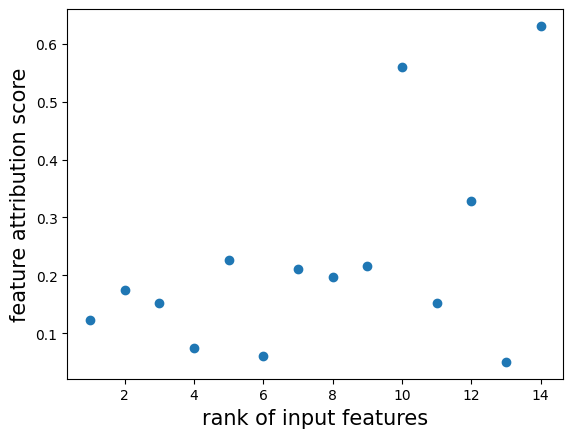

In [34]:
print(model.feature_score.cpu().detach().numpy())
import matplotlib.pyplot as plt
plt.scatter(np.arange(14)+1, model.feature_score.cpu().detach().numpy())
plt.xlabel('rank of input features', fontsize=15)
plt.ylabel('feature attribution score', fontsize=15)

In [146]:
model_output = model(dataset['train_input'])
print(model_output)

tensor([[ 0.0010],
        [-0.0018],
        [ 0.0097],
        [ 0.0005],
        [-0.0071],
        [ 0.0014],
        [-0.0167],
        [-0.0006],
        [ 0.0202],
        [ 0.0119],
        [ 0.0043],
        [ 0.0081],
        [ 0.0189],
        [ 0.0216],
        [ 0.0187],
        [ 0.0080],
        [ 0.0143],
        [-0.0025],
        [ 0.0230],
        [ 0.0166],
        [ 0.0070],
        [-0.0019],
        [ 0.0109],
        [ 0.0096],
        [ 0.0200],
        [ 0.0046],
        [ 0.0011],
        [ 0.0265],
        [ 0.0086],
        [ 0.0133],
        [ 0.0186],
        [ 0.0006],
        [ 0.0368],
        [ 0.0049],
        [-0.0046],
        [ 0.0361],
        [ 0.0106],
        [ 0.0261],
        [ 0.0047],
        [ 0.0112],
        [ 0.0319],
        [ 0.0485],
        [ 0.0159],
        [ 0.0093],
        [ 0.0257],
        [ 0.0169],
        [ 0.0148],
        [ 0.0163],
        [ 0.0413],
        [ 0.0234],
        [ 0.0097],
        [ 0.0179],
        [ 0.

In [57]:
grids = [5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(datasemodel = model.refine(10)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

saving model version 0.3


| train_loss: 1.31e+10 | test_loss: 1.44e+10 | reg: 5.44e+06 | : 100%|█| 50/50 [00:01<00:00, 47.79it


saving model version 0.4
saving model version 0.5


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 42.57it/s]


saving model version 0.6
saving model version 0.7


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:01<00:00, 35.41it/s]


saving model version 0.8
saving model version 0.9


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 50/50 [00:02<00:00, 21.24it/s]


saving model version 0.10
